In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import pandas as pd
import time
import math
from ast import literal_eval

from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

%matplotlib inline

# Data Initialization

In [2]:
classes = ["adult_males", "subadult_males", "adult_females", "juveniles", "pups", "total"]

train_path = '/Users/YINAN/Local/Sea-lions/Data/Train/'
train_dotted_path = '/Users/YINAN/Local/Sea-lions/Data/TrainDotted/'

bad_images = [3,7,9,21,30,34,71,81,89,97,151,184,215,234,242,268,290,311,331,344,380,384,406,421,469,475,490,499,507,
              530,531,605,607,614,621,638,644,687,712,721]

file_names = [str(x) + '.jpg' for x in range(0,750) if x not in bad_images]
coordinates_df = pd.DataFrame(index=file_names, columns=classes)
# read all the coordinates 
coordinates_df = pd.read_csv("./coordinates.csv", index_col='index', converters={"total": literal_eval})

In [3]:
coordinates_df.shape

(710, 6)

In [4]:
def sliding_window(image):
    patches = []
    for row in range(image.shape[0]//96):
        for col in range(image.shape[1]//96):
            patch_rgb = cv2.cvtColor(image[row*96:row*96+96, col*96:col*96+96], cv2.COLOR_BGR2RGB)
            patches.append(patch_rgb)
    return patches

def extract_patches_with_sealions(coordinates_df):
    patches = []
    count = 0
    for filename in coordinates_df.index:
        count += 1
        image = cv2.imread(train_path + filename)
        for coordinates in coordinates_df.loc[filename].total:
            thumb = image[coordinates[1]-48:coordinates[1]+48,coordinates[0]-48:coordinates[0]+48,:]
            if np.shape(thumb) == (96, 96, 3):
                patches.append(cv2.cvtColor(thumb, cv2.COLOR_BGR2RGB))
        print("\r%d file completes, with total %d"%(count, len(coordinates_df)), end='')
    return patches

def extract_patches_without_sealions(coordinates_df):
    patches = []
    count = 0
    for filename in coordinates_df.index:
        sealion_coordinates_list = coordinates_df.loc[filename].total
        image = cv2.imread(train_path + filename)
        count += 1
        for row in range(image.shape[0]//96):
            for col in range(image.shape[1]//96):
                center = (row*96+48, col*96+48)
                flag = True
                for thumb in sealion_coordinates_list:
                    if math.sqrt((center[0] - thumb[1])**2 + (center[1] - thumb[0])**2) < math.sqrt(2)*96:
                        flag = False
                        break
                if flag:
                    patch_rgb = cv2.cvtColor(image[row*96:row*96+96, col*96:col*96+96], cv2.COLOR_BGR2RGB)
                    patches.append(patch_rgb)
        print("\r%d file completes, with total %d"%(count, len(coordinates_df)), end='')
    return patches 

def get_features(patch):
    features = {}
    features["R"] = np.average(patch[:,:,0])
    features["G"] = np.average(patch[:,:,1])
    features["B"] = np.average(patch[:,:,2])
    return features

def construct_dataset(coordinate_df, pos_num, neg_num, feature_names):
    
    pos_df = pd.DataFrame(columns=feature_names)
    print("constructing pos data...")
    patches = extract_patches_with_sealions(coordinates_df=coordinates_df.sample(pos_num))
    print("\n start extracting patches...")
    for i in range(len(patches)):
        patch = patches[i]
        pos_df = pos_df.append(get_features(patch), ignore_index=True)
        print("\r%d patch completes, with total %d"%(i, len(patches)), end='')
    pos_df['class'] = 1
    
    neg_df = pd.DataFrame(columns=feature_names)
    print("\nconstructing neg data...")
    patches = extract_patches_without_sealions(coordinates_df=coordinates_df.sample(neg_num))
    print("\n start extracting patches...")
    for i in range(len(patches)):
        patch = patches[i]
        neg_df = neg_df.append(get_features(patch), ignore_index=True)
        print("\r%d patch completes, with total %d"%(i, len(patches)), end='')
    neg_df['class'] = 0
    
    total = pos_df.append(neg_df)
    print("\n"+"-"*20)
    print("Data construction completes.\npos={}, neg={}".format(len(pos_df), len(neg_df)))
    return total

def train_classifier(data, reg, threshold, random_state):
    target = 'class'
    variables = data.columns[data.columns != target]
    x_train, x_test,y_train, y_test = \
    model_selection.train_test_split(data[variables], data[target], test_size = 0.33)
    logistic = linear_model.LogisticRegression(C=reg, random_state=random_state)
    logistic.fit(x_train, y_train)
    y_pred = prediction_with_threshold(logistic, threshold, x_test)

    print("recall score is {}".format(recall_score(y_test, y_pred)))
    print("precision score is {}".format(precision_score(y_test, y_pred)))
    return logistic
    
def ClassifyWithThreshold(probabilities, threshold):
    return [+1 if x>=threshold else 0 for x in probabilities]

def prediction_with_threshold(classifier, threshold, x_test):
    return ClassifyWithThreshold(classifier.predict_proba(x_test)[:,1], threshold)
    
def classify_patch(patch, classifier, threshold):
    features = get_features(patch)
    df = pd.DataFrame.from_dict([features])
    pred = prediction_with_threshold(classifier, threshold, df[["R","G","B"]])
    return 1 if pred[0] == 1 else 0

# Pipeline

* positive patches extraction
* negative patches extraction
* train a simple logistic regression binary classifier
* testing

In [6]:
train = construct_dataset(coordinate_df=coordinates_df, pos_num=200, neg_num=10, feature_names=["R","G","B"])

constructing pos data...
200 file completes, with total 200
 start extracting patches...
19063 patch completes, with total 19064
constructing neg data...
10 file completes, with total 10
 start extracting patches...
18657 patch completes, with total 18658
--------------------
Data construction completes.
pos=19064, neg=18658


In [7]:
baseline = len(train[train['class'] == 1])/len(train)
print("precision baseline is %f"%baseline)

precision baseline is 0.505381


In [12]:
logistic_classifier = train_classifier(data=train, reg=1e-5,threshold=0.3,random_state=1)

recall score is 0.950550327005902
precision score is 0.7283060376436079


# Test the module with a new data set

In [13]:
test = construct_dataset(coordinate_df=coordinates_df, pos_num=20, neg_num=20, feature_names=["R","G","B"])

constructing pos data...
20 file completes, with total 20
 start extracting patches...
1420 patch completes, with total 1421
constructing neg data...
20 file completes, with total 20
 start extracting patches...
39045 patch completes, with total 39046
--------------------
Data construction completes.
pos=1421, neg=39046


In [14]:
baseline = len(test[test['class'] == 1])/len(test)
print("baseline is %f"%baseline)

baseline is 0.035115


In [15]:
target = 'class'
variables = test.columns[test.columns != target]
y = test[target]
y_pred = prediction_with_threshold(classifier=logistic_classifier, threshold=0.2, x_test=test[variables])
print("recall score is {}".format(recall_score(y, y_pred)))
print("precision score is {}".format(precision_score(y, y_pred)))

recall score is 0.9767769176636172
precision score is 0.05194416376632611


In [16]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true=y, y_score=y_pred)

0.66398903251413199

# Real situation testing

When a new image arrives, we need to first use sliding window to extract all the patches without overlapping. Then using the logistic regresion classifier to classify the patches.

In [80]:
test_image = cv2.imread(train_path + '800.jpg')
patches = sliding_window(test_image)

In [81]:
pos = []
neg = []
for patch in patches:
    p = classify_patch(patch, logistic_classifier, 0.2)
    if p == 1:
        pos.append(patch)
    else:
        neg.append(patch)

In [82]:
print("Total patches number is %d\npos number is %d, neg number is %d"%(len(patches), len(pos), len(neg)))

Total patches number is 1768
pos number is 441, neg number is 1327


pos examples


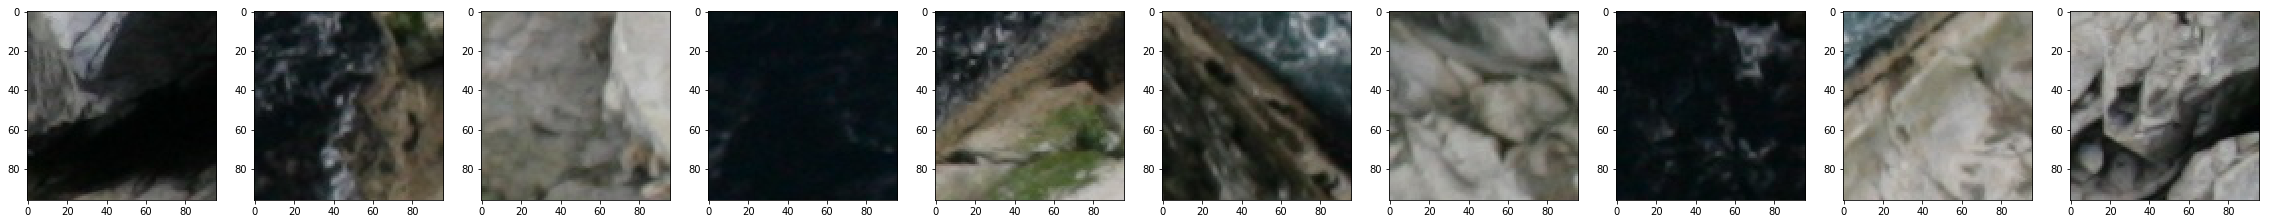

In [89]:
f, ax = plt.subplots(1,10, figsize=(40,10))
random_index = np.random.choice(len(pos), 10, replace=True)
for index, a in enumerate(ax):
    a.imshow(pos[random_index[index]])
print("pos examples")

neg examples


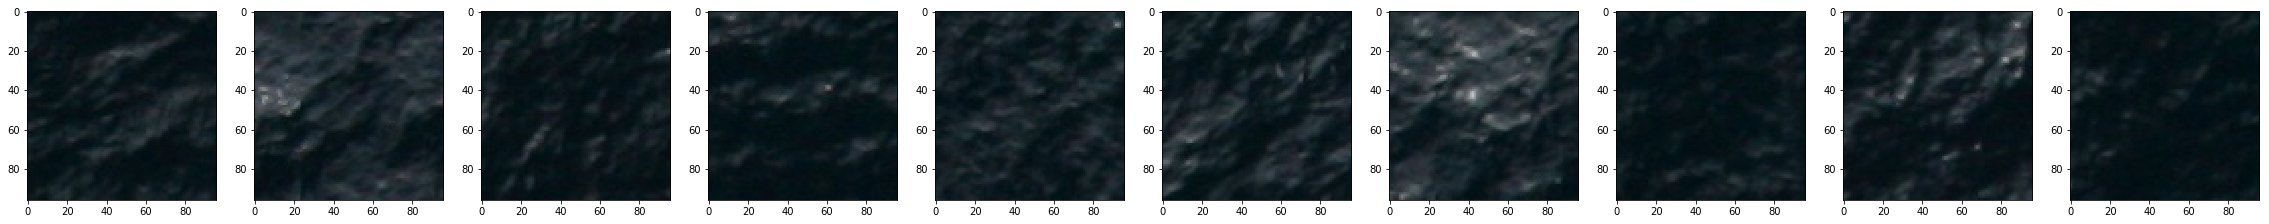

In [90]:
f, ax = plt.subplots(1,10, figsize=(40,10))
random_index = np.random.choice(len(neg), 10, replace=True)
for index, a in enumerate(ax):
    a.imshow(neg[random_index[index]])
print("neg examples")